<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install umap-learn[plot] hdbscan gower
!wget -O funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1026_funcs.py?raw=1
!wget -O 1026_used_device_data.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1026_used_device_data.csv?raw=1

## HDBSCAN for mixed data

In [2]:
import random

import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

import umap
import umap.plot as uplot

import hdbscan
import gower

random.seed(42)
sns.set_theme()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

### The dataset

**Used Phones & Tablets Pricing Dataset**

This dataset provides comprehensive details on various used mobile phones and tablets.

1. **device_brand**: The manufacturer or brand name of the device.
   
2. **os**: The operating system running on the device.
3. **screen_size**: The size of the device's screen in cm.
4. **4g**: Boolean indicating whether the device supports 4G connectivity.
5. **5g**: Boolean indicating whether the device supports 5G connectivity.
6. **rear_camera_mp**: The resolution of the rear camera, measured in megapixels.
7. **front_camera_mp**: The resolution of the front camera, also in megapixels.
8. **internal_memory**: Storage capacity of the device in gigabytes.
9.  **ram**: The amount of random-access memory (RAM) in gigabytes.
10. **battery**: Battery capacity, typically measured in milliampere-hours (mAh).
11. **weight**: The weight of the device, usually in grams.
12. **release_year**: The year the device was released.
13. **days_used**: The number of days the device has been used.
14. **normalized_used_price**: The price of the used device, normalized to a standard scale.
15. **normalized_new_price**: The original price of the device when new, normalized to a standard scale.

Citation: https://www.kaggle.com/datasets/ahsan81/used-handheld-device-data/data

In [3]:
# Load phone data
phone_df = pd.read_csv('1026_used_device_data.csv')
phone_df.head()
# we have a mix of categorical and numerical data

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [4]:
phone_df.shape

(3454, 15)

In [5]:
# Get feature info
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

In [6]:
# Find missing values
phone_df.isna().sum(axis=0)
# we have a significant portion of missing values for rear camera
# so might be that some devices don't have rear camera

,0
device_brand,0
os,0
screen_size,0
4g,0
5g,0
rear_camera_mp,179
front_camera_mp,2
internal_memory,4
ram,4
battery,6


In [7]:
phone_df[phone_df.isna().sum(axis=1) > 0].head(20)
# as you can see these devices have a release year like 2020, 2019
# so this device is probably have a rear camera
# so this means that these values are simply not available or not collected for these devices
# and for this reason we will drop all the rows containing missing values

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
59,Infinix,Android,17.32,yes,no,NaN,8.0,32.00,2.00,6000.0,209.0,2020,245,4.282068,4.597642
60,Infinix,Android,15.39,yes,no,NaN,8.0,64.00,4.00,5000.0,185.0,2020,173,4.363608,4.711780
61,Infinix,Android,15.39,yes,no,NaN,8.0,32.00,2.00,5000.0,185.0,2020,256,4.181439,4.505460
62,Infinix,Android,15.39,yes,no,NaN,16.0,32.00,3.00,4000.0,178.0,2019,316,4.555244,4.602166
63,Infinix,Android,15.29,yes,no,NaN,16.0,32.00,2.00,4000.0,165.0,2019,468,4.416670,4.871297
64,Lava,Android,14.50,yes,no,NaN,5.0,32.00,2.00,3200.0,150.0,2020,356,3.989910,4.381026
97,Meizu,Android,15.39,yes,yes,NaN,20.0,128.00,8.00,4500.0,199.0,2020,186,5.167867,6.272028
98,Meizu,Android,15.37,yes,no,NaN,16.0,128.00,6.00,4500.0,183.0,2019,449,4.665512,5.526329
99,Meizu,Android,15.37,yes,no,NaN,8.0,32.00,2.00,4000.0,184.0,2019,190,4.290185,5.195177
100,Meizu,Android,15.29,yes,no,NaN,20.0,128.00,6.00,3600.0,166.0,2019,459,4.721085,5.830679


In [8]:
# Drop missing values
phone_df = phone_df.dropna()

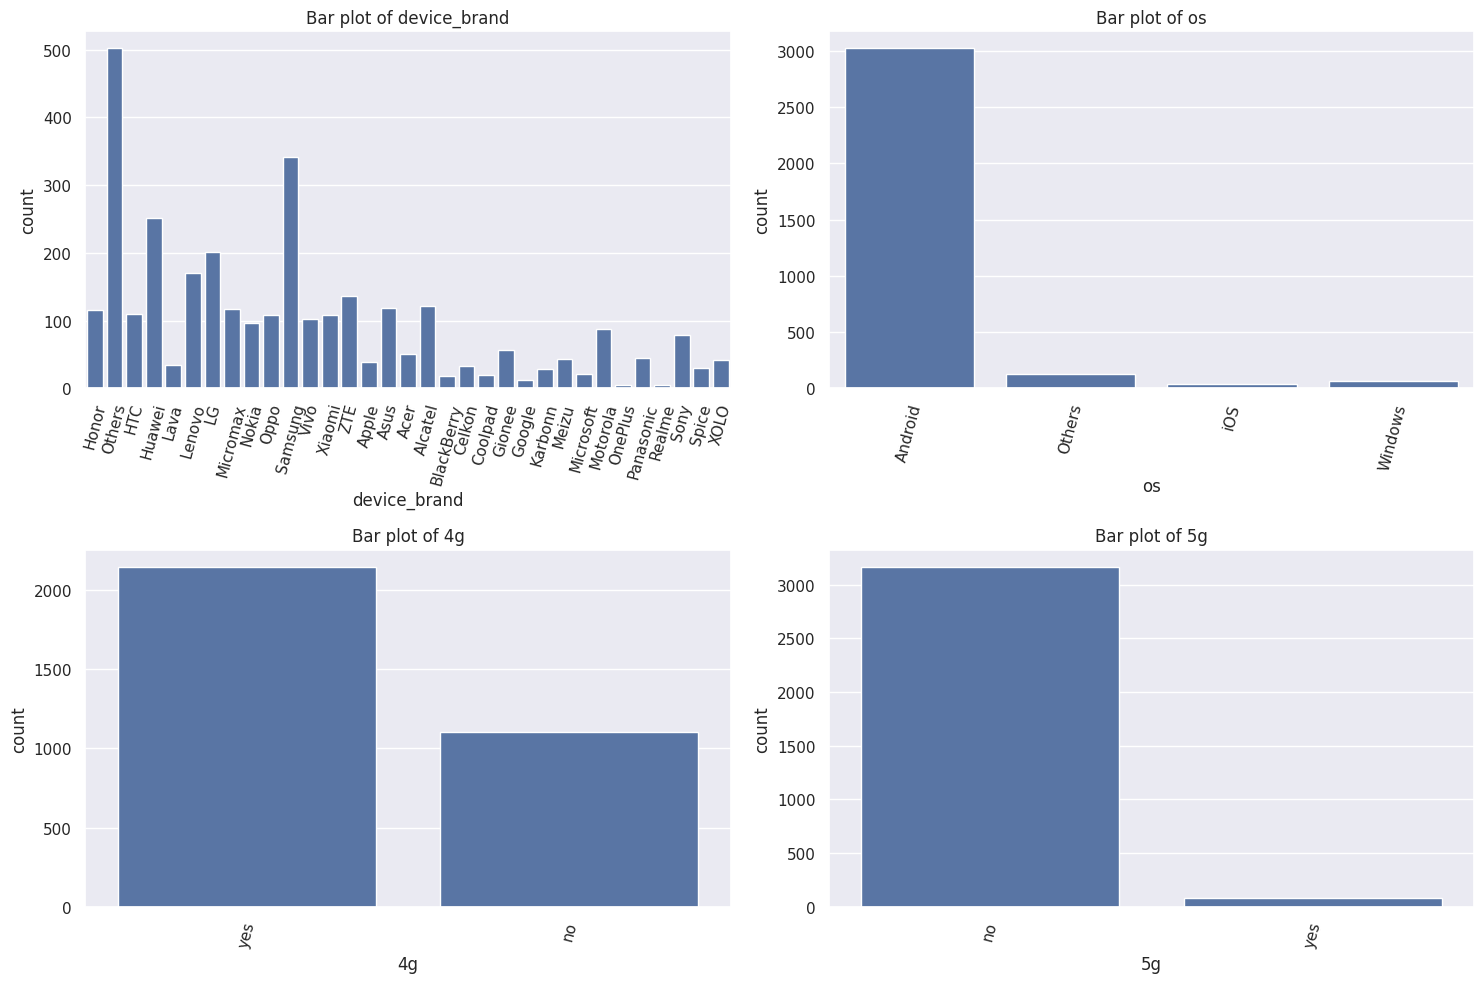

In [9]:
# Get only the categorical columns
cat_cols = phone_df.select_dtypes(include=['object', 'bool']).columns

# Determine the number of rows needed for the plot
n_rows = int(np.ceil(len(cat_cols) / 2))

# Create a figure and axes with subplots()
fig, axs = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows)) # Adjust the size as necessary
axs = axs.ravel()  # this makes it easier to iterate over the axes

# Loop through the columns and create the bar plots
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=phone_df, ax=axs[i])
    axs[i].set_title(f'Bar plot of {col}')
    axs[i].tick_params(axis='x', rotation=75)  # Optional: only if x-tick labels are long

# Remove any unused subplots
if len(cat_cols) % 2:
    fig.delaxes(axs[-1])

#
plt.tight_layout()
plt.show()

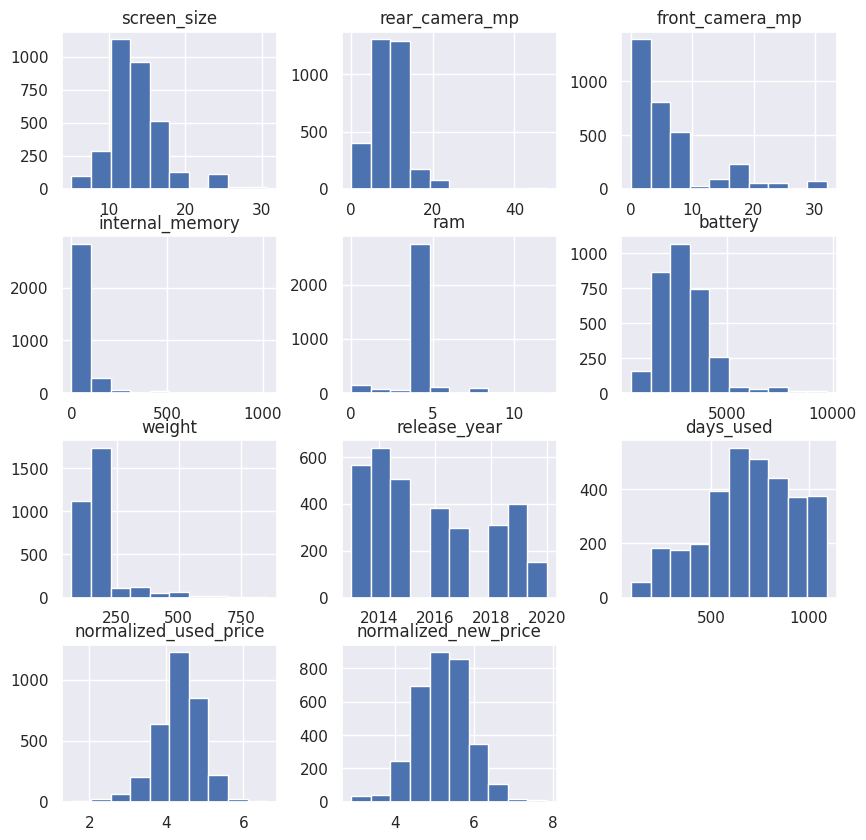

In [10]:
# Plot numerical features
_ = phone_df.hist(figsize=(10,10))
# our features are on different scales
# also we have a couple of skewed features having different levels of skewness

In [11]:
# We will not use price for clustering since we want
# to cluster based on phone characteristics
original_phone_df = phone_df.copy()
phone_df = phone_df.drop(columns=['normalized_used_price', 'normalized_new_price'])

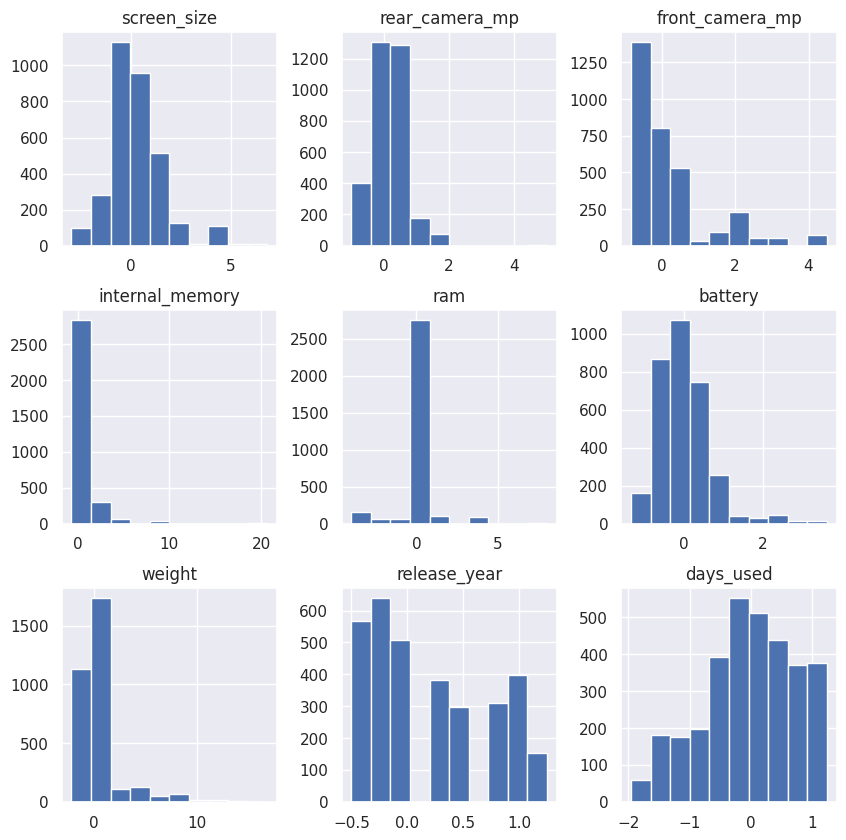

In [12]:
numeric_col_names = phone_df.select_dtypes(include=[np.number]).columns.tolist()

# the robust scaler should work in this case because neither of our features is extremely skewed
phone_df[numeric_col_names] = RobustScaler().fit_transform(phone_df[numeric_col_names])
_ = phone_df.hist(figsize=(10,10))
# after the robust scaling, all of our features are on similar scale

### HDBSCAN clustering

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

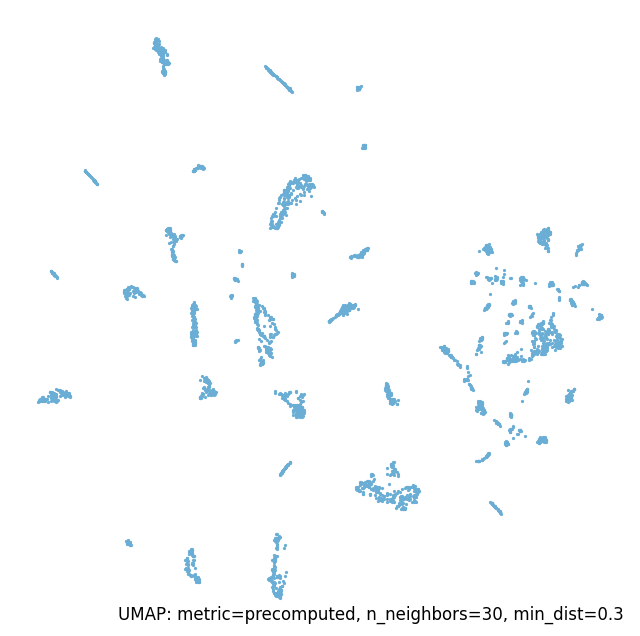

In [13]:
categ_cool_bool = [col in cat_cols for col in phone_df.columns]

# Find gower distance
dist_matrix = gower.gower_matrix(phone_df, cat_features=categ_cool_bool)

# Umap embedding
game_umap = umap.UMAP(metric='precomputed', n_neighbors=30, min_dist=0.3).fit(dist_matrix)

uplot.points(game_umap)
# we can observe many groups on our Umap plot

In [14]:
# Run HDDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=30, gen_min_span_tree=True, metric='precomputed')
clusterer.fit(dist_matrix.astype(np.double)) # we will provide our pairwise Gower distance

np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([661,  34,  43,  94,  62,  49,  39, 102,  97,  39, 106,  50,  39,
        108, 110, 121, 259,  79,  30,  90,  68,  73,  31, 138,  42, 224,
         87, 179, 199]))

DBCV : 0.23020883153423882
Silouethe : 0.37347468733787537


<Axes: >

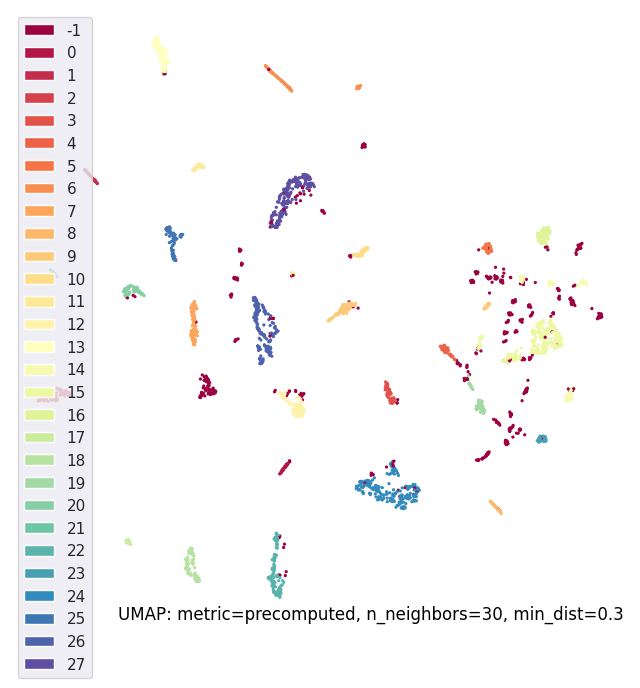

In [15]:
# Evaluate the clustering
dbcv = hdbscan.validity.validity_index(
    dist_matrix.astype(np.double),
    labels=clusterer.labels_,
    metric='precomputed',
    d = phone_df.shape[1],
    per_cluster_scores=True
)

non_noise_idx = np.where(clusterer.labels_!=-1)[0]

sil_score = silhouette_score(
    dist_matrix[non_noise_idx,:][:, non_noise_idx],
    clusterer.labels_[non_noise_idx],
    metric='precomputed'
)

print('DBCV : {}'.format(dbcv[0]))
print('Silouethe : {}'.format(sil_score))

uplot.points(game_umap, labels=clusterer.labels_)
# these scores are not too bad.
# by looking at the Umap plot you can see that Hdbscan has managed to discover all of these small groups of data points

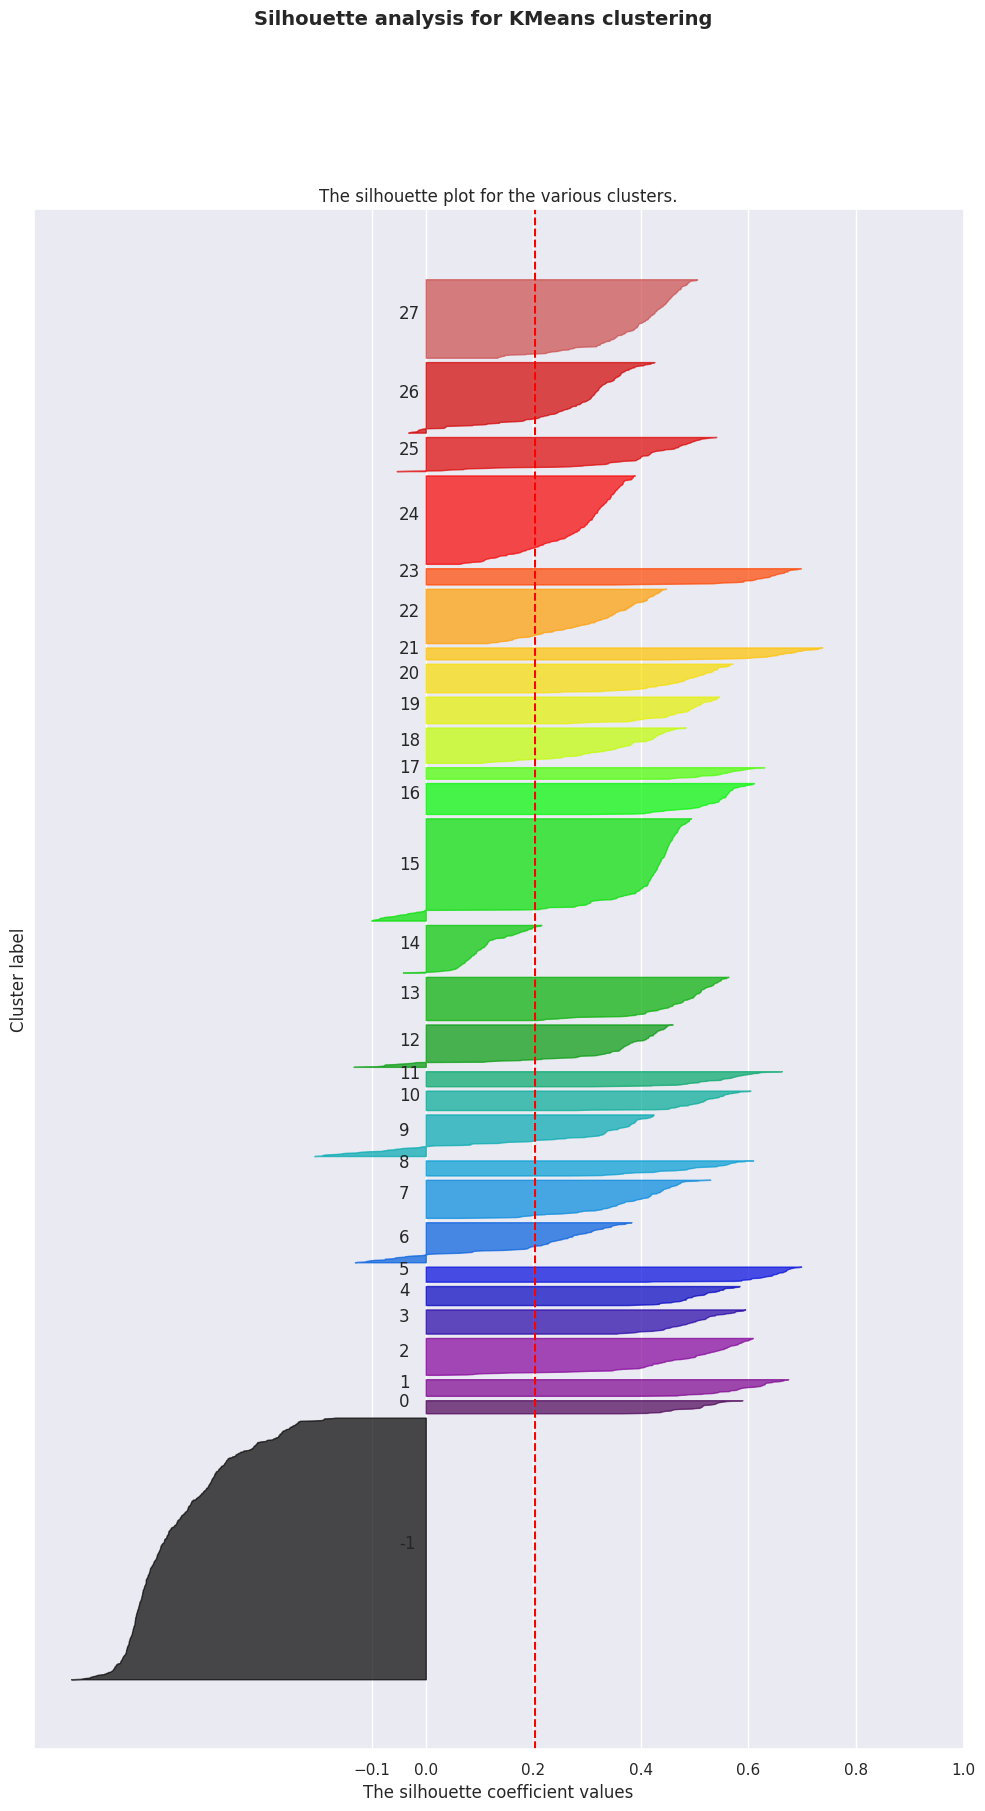

0.20321307589022028

In [16]:
# we will use our custom function in order to further analyze quality of our clusters by plotting per cluster per sample silhouette scores
# this function represents a slight modification of the same function from the agglomerative clustering chapter
# so in this function, almost all of the code is the same
# but we will use this a little piece of code in order to account for the minus one which is generated by hdbscan
# so basically we will increment our cluster names by one, in order to remove minus one
# but we will use this minus one in order to later subtract one from our cluster names when annotating our clusters on the silhouette plot
from funcs import plot_silouethes_dens

plot_silouethes_dens(
    data_df = dist_matrix.astype(np.double),
    clusters=clusterer.labels_ ,
    distance_measure='precomputed',
    figsize=(12,20),
)
# our clusters are quite stable and the overall silhouette score is not bad

In [17]:
pd.DataFrame(dbcv[1])
# if we plot per cluster db CV, you can also see that
# the scores for majority of clusters are quite high

,0
0,0.476364
1,0.654771
2,0.466787
3,0.520058
4,0.415355
5,0.228701
6,0.003343
7,0.469432
8,0.481617
9,0.000400


### Characterize clusters

In [19]:
# Use original features, remove noise
numeric_col_names = original_phone_df.select_dtypes(include=[np.number]).columns.tolist()
original_phone_df['cluster'] = clusterer.labels_
original_phone_df = original_phone_df[original_phone_df['cluster'] != -1]

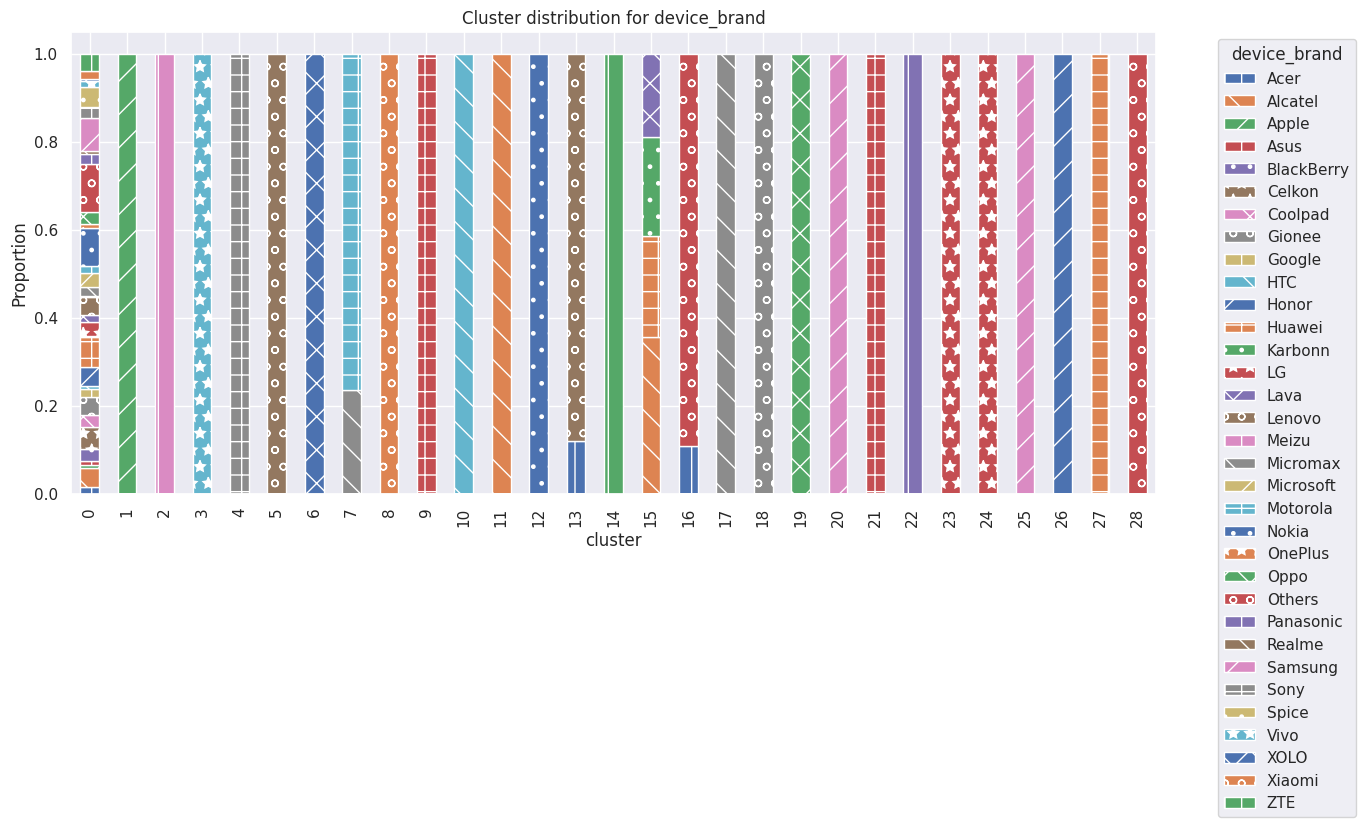

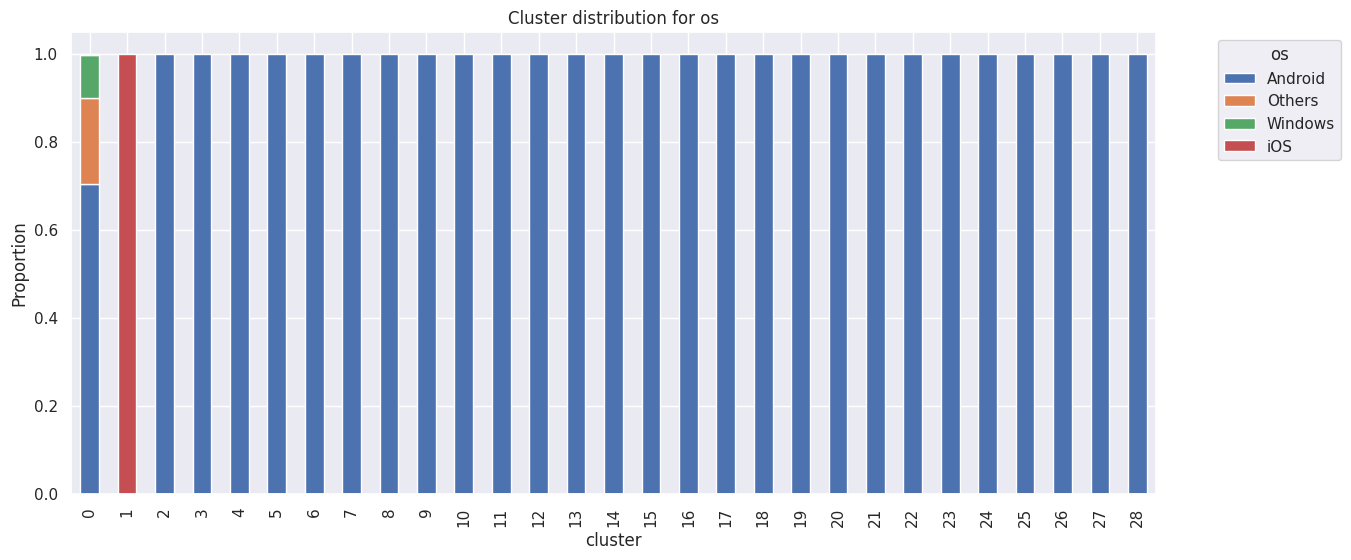

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


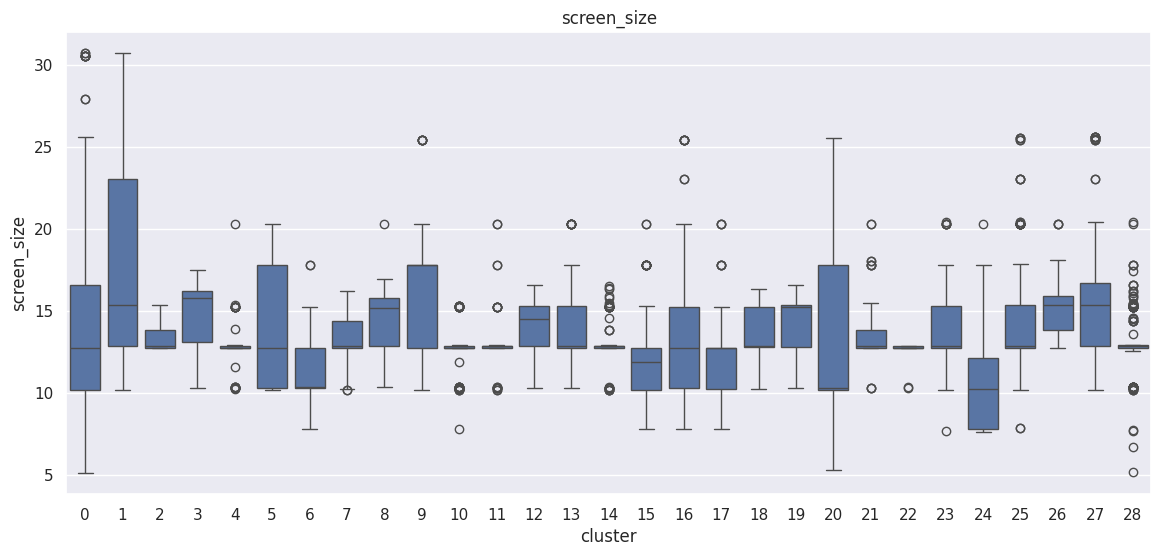

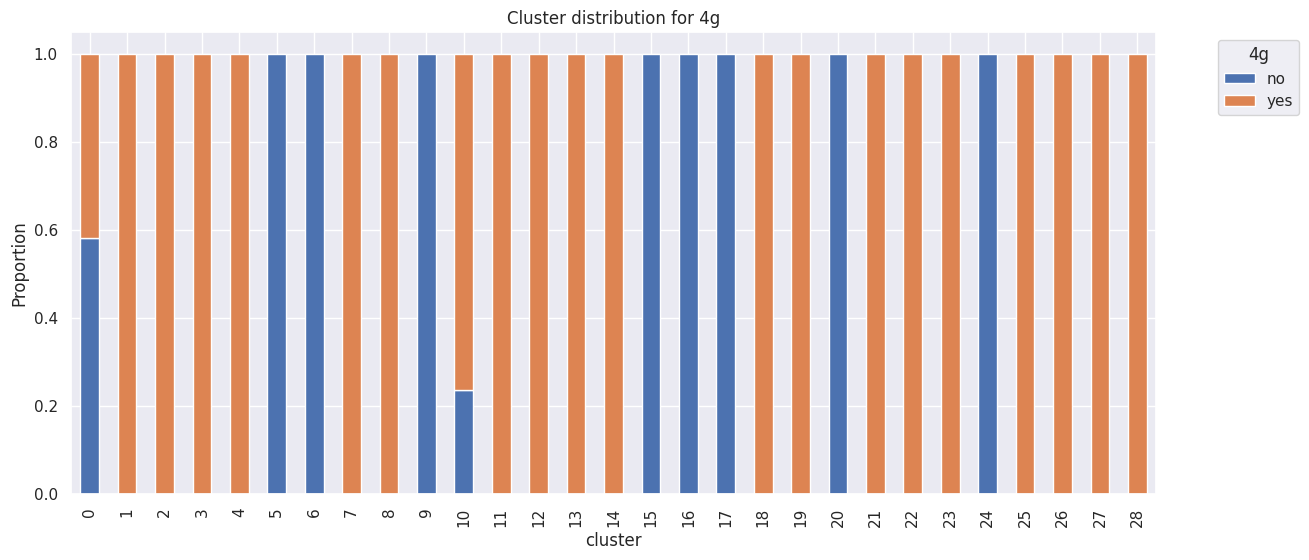

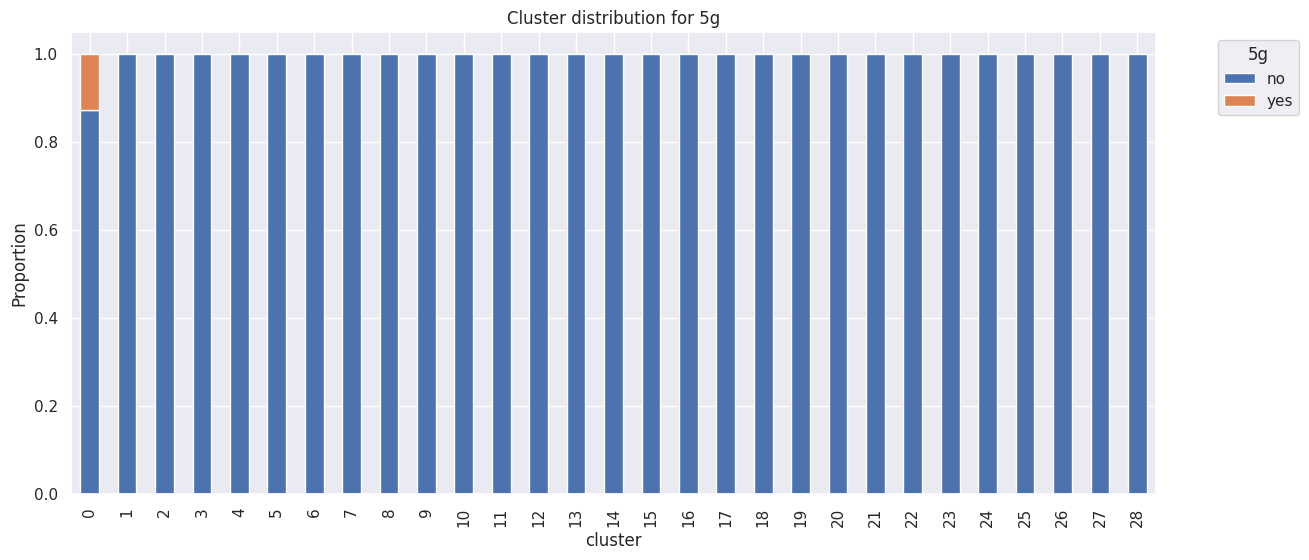

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

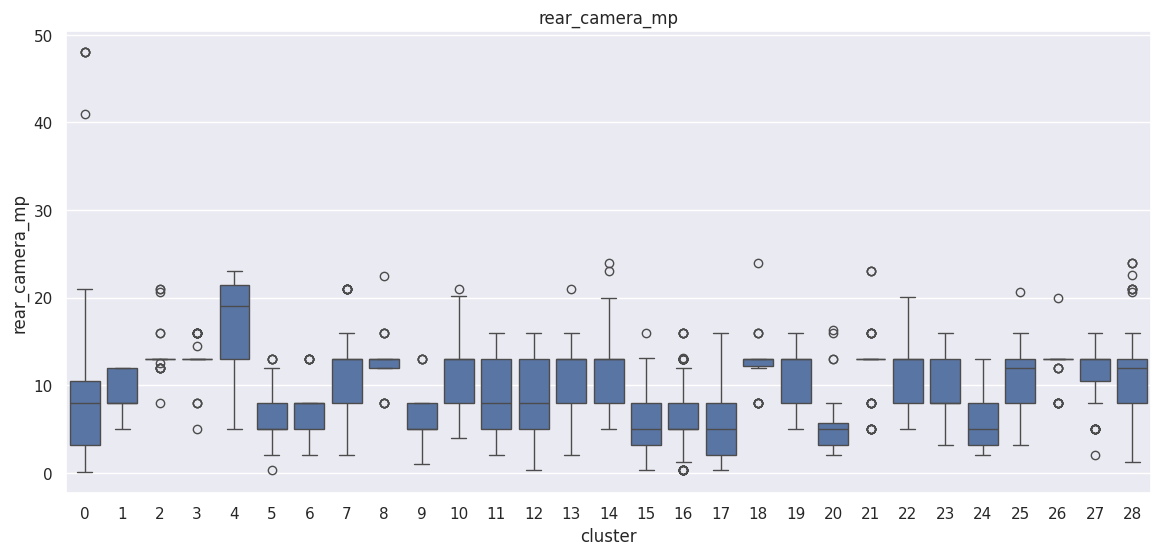

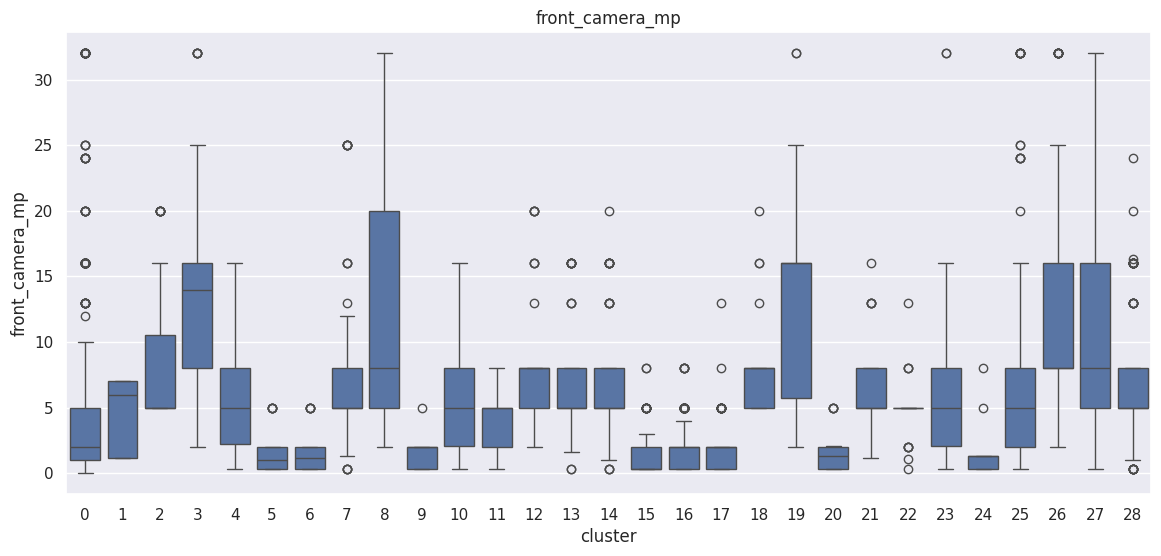

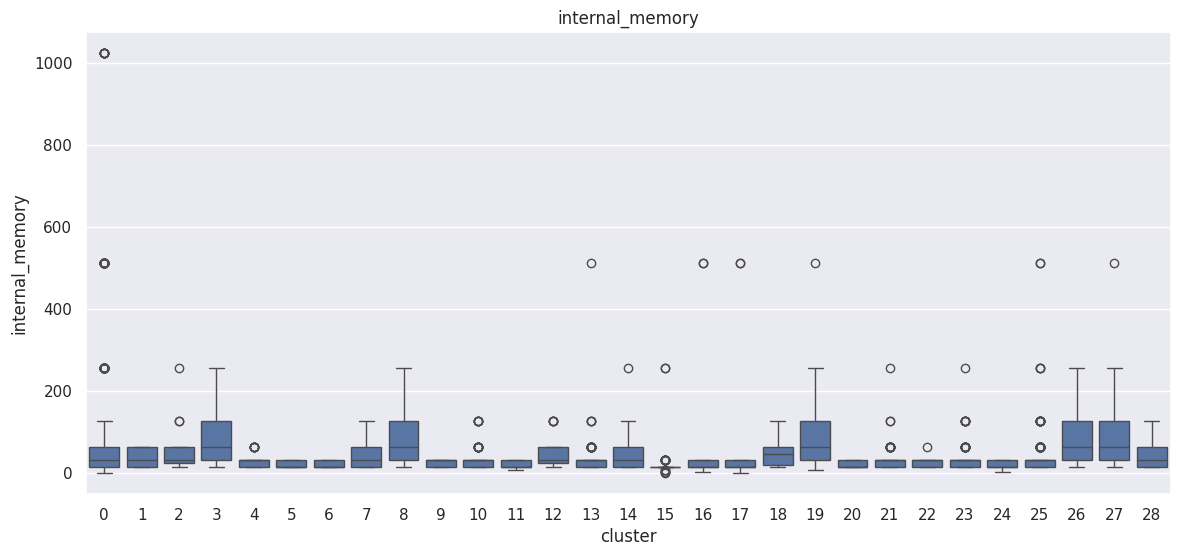

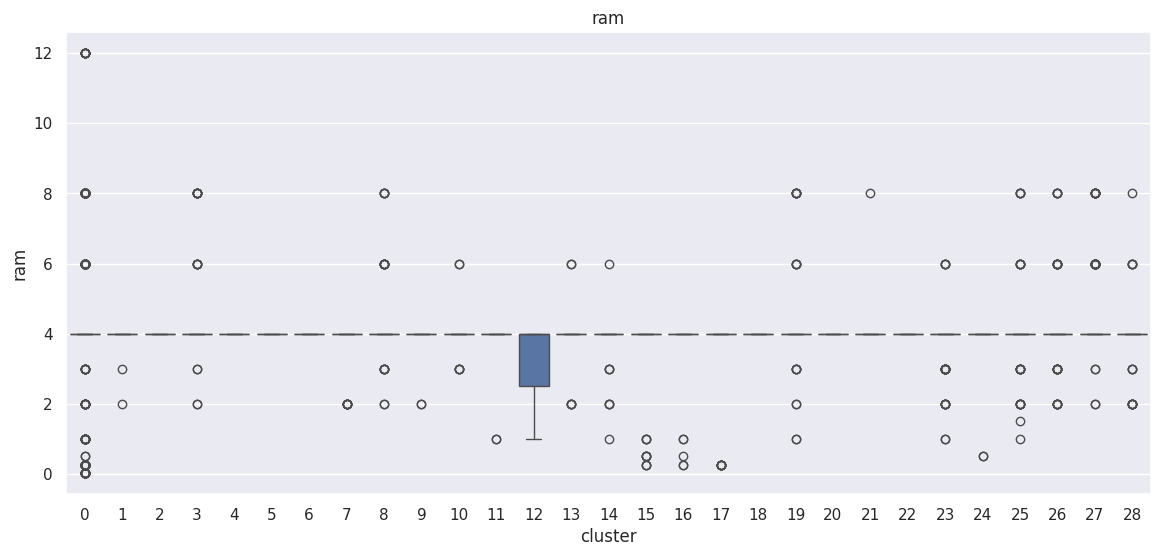

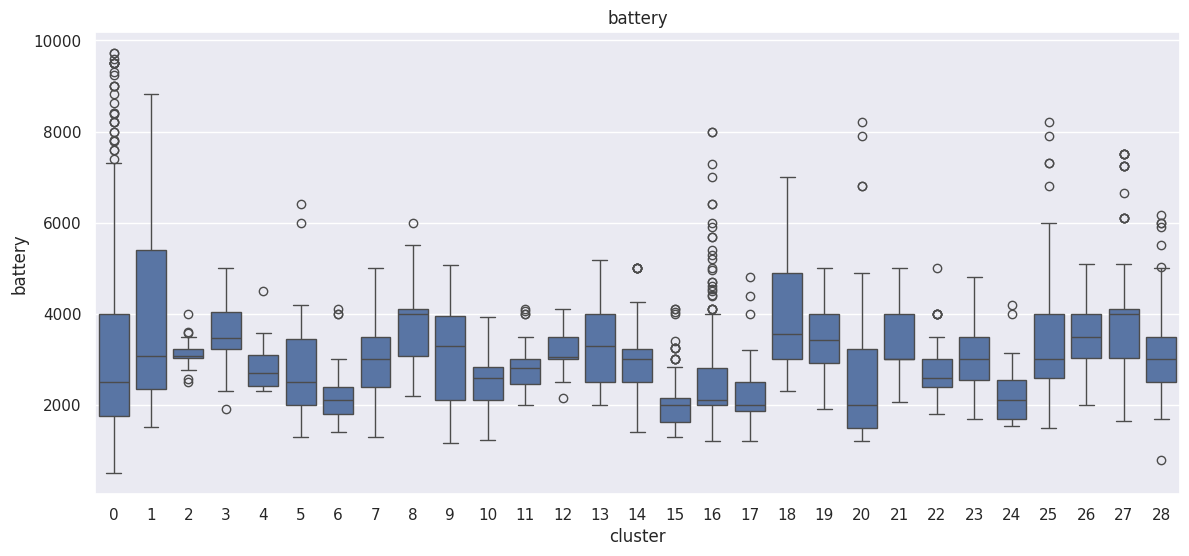

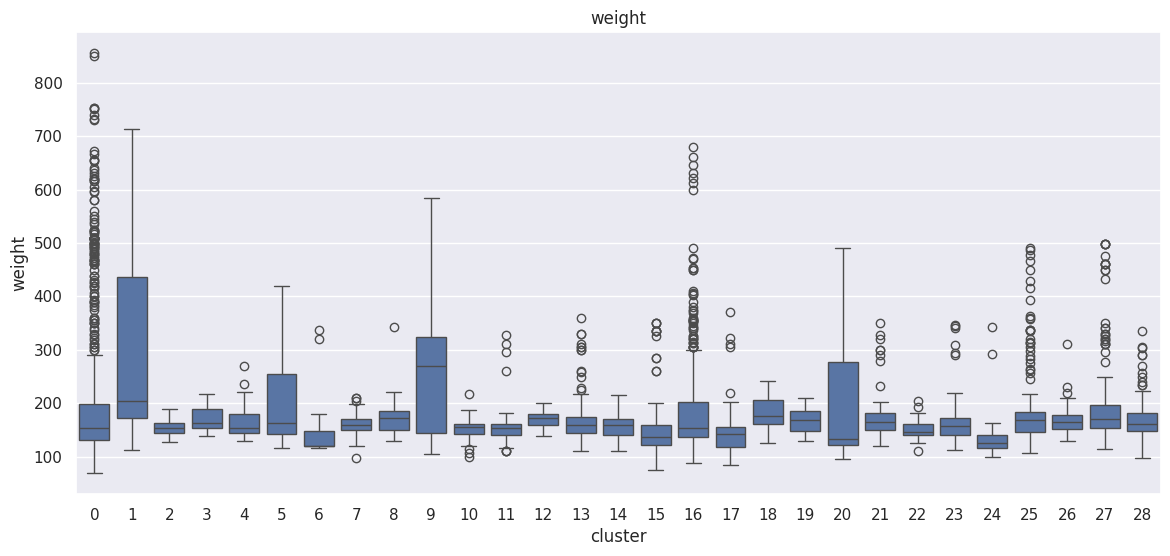

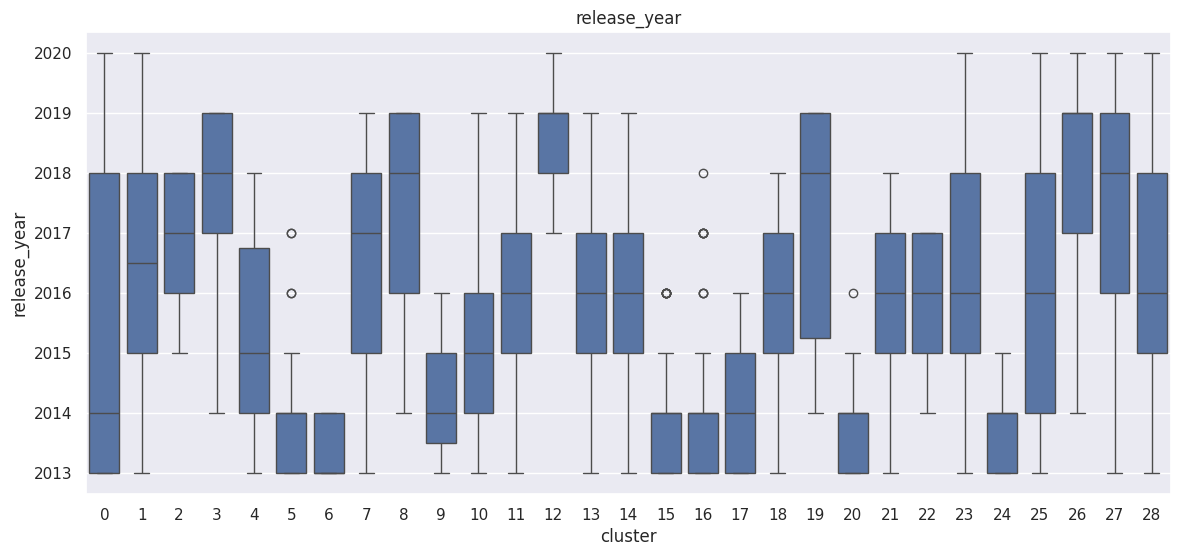

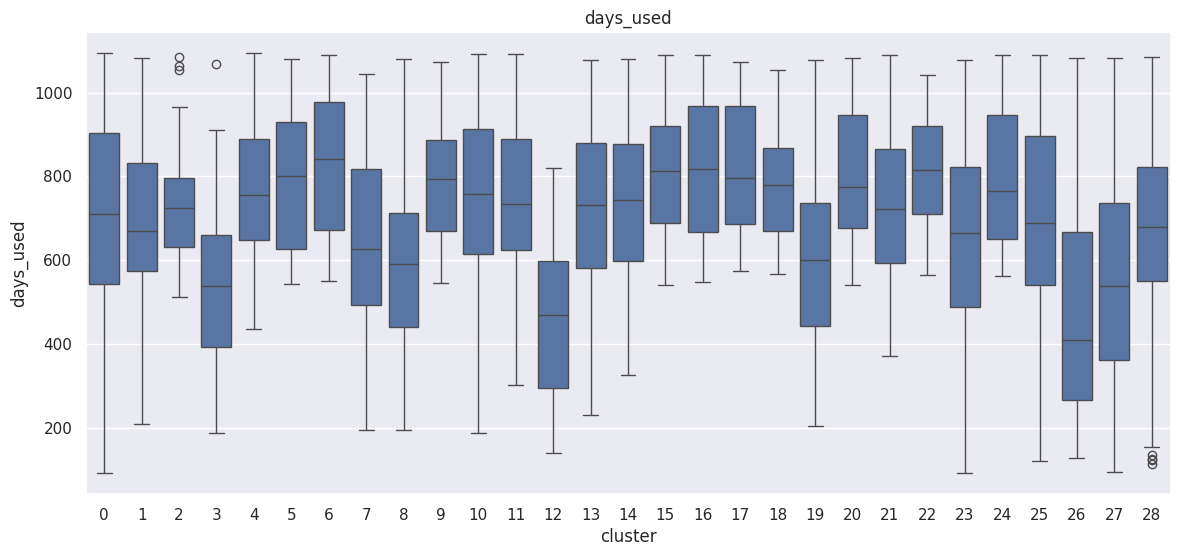

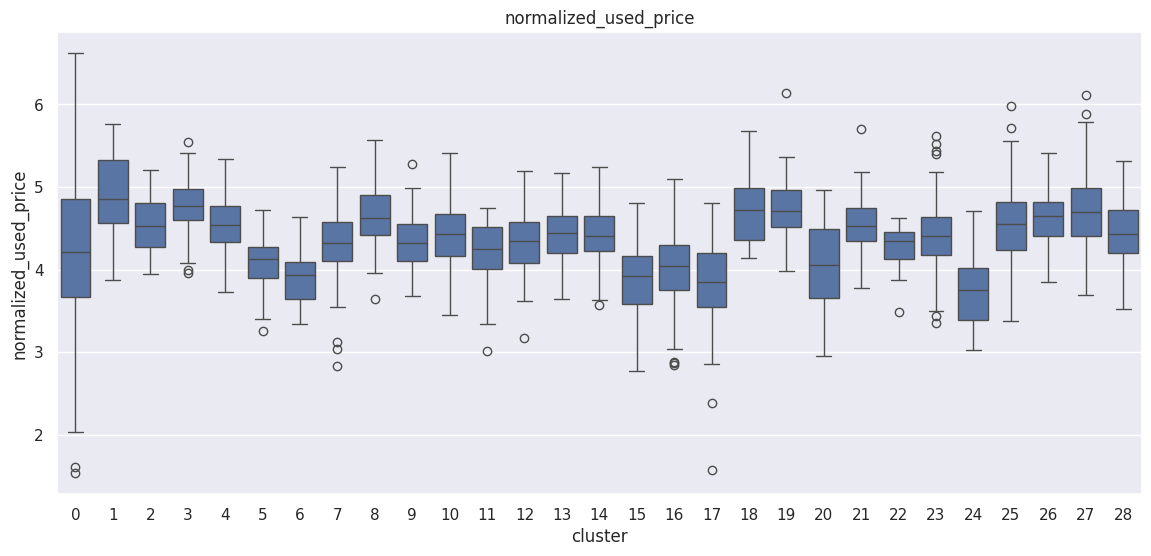

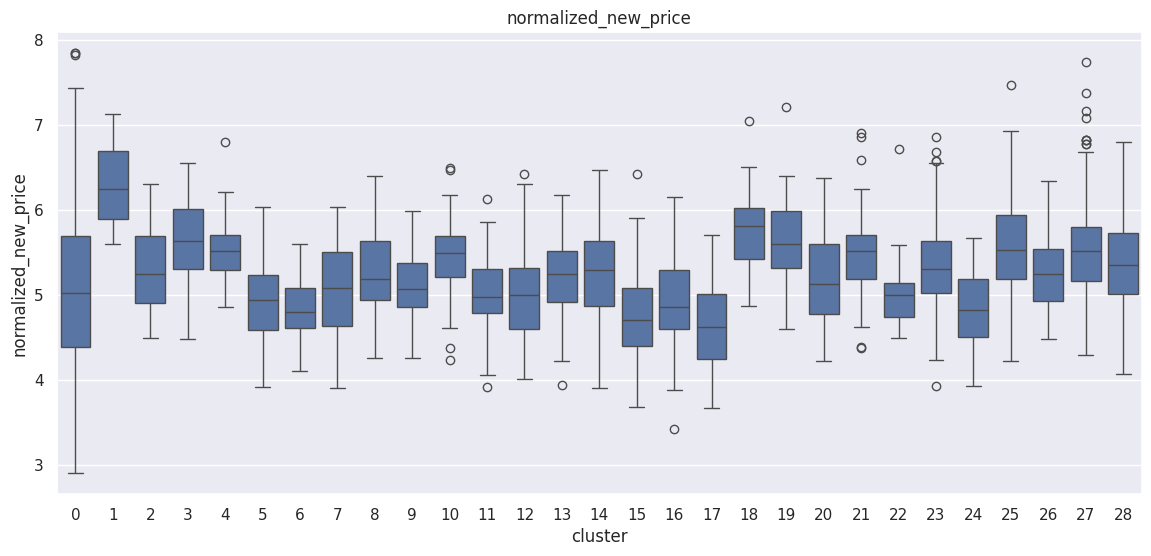

In [20]:
# Plot features
for feature in original_phone_df.columns:
    if feature != 'cluster':
        if feature in numeric_col_names:
            plt.figure(figsize=(14, 6))
            sns.boxplot(original_phone_df, x='cluster', y=feature)
            plt.title(feature)
        else:
            proportions = original_phone_df.groupby(
                'cluster'
            )[feature].value_counts(
                normalize=True
            ).unstack()

            # Create stacked bar plot
            ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6))
            plt.title(f'Cluster distribution for {feature}')
            plt.ylabel('Proportion')

            if proportions.shape[1] > 15:
                # Define hatch patterns
                patterns = ["|" , "\\" , "/" , "+" , ".", "*","x", "o"]

                # Apply hatch patterns
                for i, bar_container in enumerate(ax.containers):
                    hatch = patterns[i % len(patterns)]  # Cycle through patterns
                    for bar in bar_container:
                        bar.set_hatch(hatch)

            # Add legend
            plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

            # Get category labels
            category_labels = proportions.columns.tolist()[::-1]
            plt.show()
# we can use these plots in order to characterize our clusters, in order to give each and every cluster
# an identity, and in order to determine what sets certain clusters apart